# Podstawy uczenia maszynowego - tutorial 2: Feature selection and extraction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Przygotowanie zbiorów danych

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from copy import deepcopy

In [8]:
# Zbiór danych medycznych pacjentów pozwalający na diagnostykę raka płuc

cancer = datasets.load_breast_cancer()
cancer.data = scale(cancer.data)

cancer_reduced = deepcopy(cancer)

In [9]:
# zbiór danych pozwalający przewidywać, czy małżeństwo się rozpadnie na podstawie odpowiedzi (w skali 0-4) na 56 pytań

divorces = pd.read_csv('./datasets/divorce.csv', sep=';')

# treści pytań są przechowywane w osobnym pliku
with open('./datasets/questions.csv') as file:
    questions = np.array(file.read().split('\n'))

divorces = {
    'data': divorces.drop(labels=['Class'], axis=1).astype(float),
    'target': list(divorces['Class']),
    'feature_names': questions
}

divorces['data'] = scale(divorces['data'])

divorces_reduced = deepcopy(divorces)

## Selekcja cech

Selekcja cech to ograniczenie liczby atrybutów danych, na których pracuje model, przez odrzucenie najmniej użytecznych z nich. Taka rezygnacja z części danych pozwala osiągnąć konkretne korzyści:
* redukcja wymiarów - odrzucenie części cech oznacza zmniejszenie wymiarowości problemu, co ułatwia uniknięcie przetrenowania modelu
* uproszczenie modelu - model pracujący na mniejszej liczbie cech jest bardziej zrozumiały i łatwiej identyfikować w nim problemy
* lepsze wyniki - cechy niezwiązane z badaną właściwością mogą w sposób losowy zaburzać otrzymywane wyniki
* poprawa wydajności - mało istotne cechy są przetwarzane niepotrzebnie

### Metody Selekcji cech

#### 1. Odrzucenie cech niecharakterystycznych

Cechy, które wykazują niewielką zmienność pomiędzy próbkami, prawdopodobnie nie niosą szczególnie użytecznej informacji - zazwyczaj nie można na ich podstawie dokonać klasyfikacji (choć warto zachować ostrożność przy zbiorach danych o silnej dysproporcji pomiędzy licznościami klas oraz cechach mogących przyjmować wartości z niewielkiego zakresu). Cechy takie można rozpoznać po niewielkiej wariancji - stąd najprostsze podejście do selekcji cech może polegać na ich przefiltrowaniu i odrzuceniu tych o zbyt niskiej wariancji.

In [10]:
from sklearn.feature_selection import VarianceThreshold

In [11]:
# variance should equal, because ...

selector = VarianceThreshold()
cancer_reduced.data = selector.fit_transform(cancer.data)


# lista atrybutów wymaga zaktualizowania, selector.get_support() zwraca indeksy wybranych cech
cancer_reduced['feature_names'] = cancer['feature_names'][selector.get_support(indices=True)]

In [12]:
selector = VarianceThreshold()
divorces_reduced['data'] = selector.fit_transform(divorces['data'])

divorces_reduced['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

#### 2. Odrzucenie cech niezwiązanych z badaną właściwością

Możemy spróbować przewidzieć, na ile każda z cech jest związana z badaną właściwością, i odrzucić te, dla których związek jest luźny. Możliwe są dwa zasadnicze podejścia:

##### 2.1. Obliczenie korelacji

Najprostszym sposobem określenia, czy cecha jest związana z inną (w szczególności - przynależnością do danej klasy) jest obliczenie korelacji między nimi.

In [13]:
def filter_correlation(X, Y, feature_names, n_features):
    scores = [abs(np.corrcoef(feature, Y))[0, 1] for feature in X.T]
    selected_indices = np.argsort(scores)[:n_features]
    data = X.T[selected_indices].T
    selected_feature_names = feature_names[selected_indices]
    return data, selected_feature_names

In [14]:
cancer_reduced.data, cancer_reduced.feature_names = filter_correlation(cancer.data, cancer.target, cancer.feature_names, 15)

In [15]:
divorces_reduced['data'], divorces_reduced['feature_names'] = \
    filter_correlation(divorces['data'], divorces['target'], divorces['feature_names'], 40)

##### 2.2. Inne statystyki

Alternatywnie, możemy wykorzystać inną statystykę, której wartość rośnie wraz ze wzrostem różnicy wartości w dwóch grupach - np. ANOVA (częstym wyborem jest miara Chi-Square, nie nadaje się ona jednak do znormalizowanych danych - nie dopuszcza wartości ujemnych, konieczne więc byłoby dodatkowe przesunięcie danych). 

W tym celu zakładamy, że badana cecha (nazwijmy ją A) nie ma związku z przynależnością próbki do określonej klasy (oznaczmy ją przez C). Opierając się na tym założeniu, obliczamy, ile próbek z każdą możliwą wartością cechy A powinno należeć do klasy C (jako liczba próbek o danej wartości cechy A * liczba próbek w ekperymencie należących do klasy C / liczba wszystkich próbek),
i obliczamy wartość wybranej statystyki na podstawie różnic pomiędzy otrzymanymi wartościami a rzeczywistymi danymi.

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [21]:
selector = SelectKBest(f_classif, k=20)

cancer_reduced.data = selector.fit_transform(cancer.data, cancer.target)
cancer_reduced.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [22]:
selector = SelectKBest(f_classif, k=30)

divorces_reduced['data'] = selector.fit_transform(divorces['data'], divorces['target'])
divorces_reduced['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

#### 3. Próbne wytrenowanie modelu

##### 3.1. Odfiltrowanie cech nieznaczących

Zamiast "ręcznie" znajdować i usuwać mało istotne cechy, możemy spróbować wytrenować na naszych danych model, który ucząc się "przy okazji" zapisuje istotność cech, i usunąć te, które nie mają dużego znaczenia w podejmowaniu decyzji przez model. Aby zastosować takie podejści, konieczny jest wybór modelu, który udostępnia istotność cech - w przypadku Scikit-learn są to modele posiadające pole coef_ lub feature_importances_.

In [23]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

In [24]:
classifier = ExtraTreesClassifier(n_estimators=50)

classifier = classifier.fit(cancer.data, cancer.target)
selector = SelectFromModel(classifier, prefit=True)

cancer_reduced.data = selector.transform(cancer.data)
cancer_reduced.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [25]:
classifier = ExtraTreesClassifier(n_estimators=50)

classifier = classifier.fit(divorces['data'], divorces['target'])
selector = SelectFromModel(classifier, prefit=True)

divorces_reduced['data'] = selector.transform(divorces['data'])
divorces_reduced['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

##### 3.2. Rekurencyjny wybór zadanej liczby najlepszych cech

Jeżeli chcemy ograniczyć liczbę cech do konkretnej wartości, powyższe podejście można zmodyfikować: zamiast wybierać cechy powyżej określonej granicy, lepszym podejściem może być odrzucenie najsłabszej z cech (lub kilku najgorszych) i rekurencyjne powtarzanie procesu, aż do osiągnięcia zadanej ich liczby.

In [26]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

In [27]:
estimator = ExtraTreesClassifier(n_estimators=50)
selector = RFE(estimator, 20, step=3)

cancer_reduced.data = selector.fit_transform(cancer.data, cancer.target)
cancer_reduced.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [28]:
estimator = ExtraTreesClassifier(n_estimators=50)
selector = RFE(estimator, 30, step=3)

divorces_reduced['data'] = selector.fit_transform(divorces['data'], divorces['target'])
divorces_reduced['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

## Wizualizacja

Wizualizację ważności poszczególnych cech najłatwiej jest oprzeć o próbne wytrenowanie modelu i odczytanie wartości z pola *feature_importances_*

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

classifier = ExtraTreesClassifier(n_estimators=50)

def plot_feature_importances(classifier, names, size=None):
    sorted_indices = np.argsort(classifier.feature_importances_)
    labels = names[sorted_indices][::-1]
    Y = classifier.feature_importances_[sorted_indices][::-1]
    X = [i for i in range(len(labels))]
    if size is not None:
        plt.figure(figsize = size)
    plt.bar(X, Y, tick_label=labels)
    plt.xticks(rotation='vertical')
    plt.show()

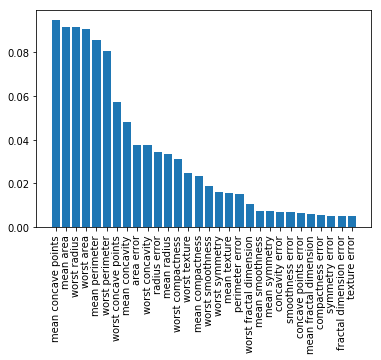

In [30]:
classifier = classifier.fit(cancer.data, cancer.target)
plot_feature_importances(classifier, cancer.feature_names)

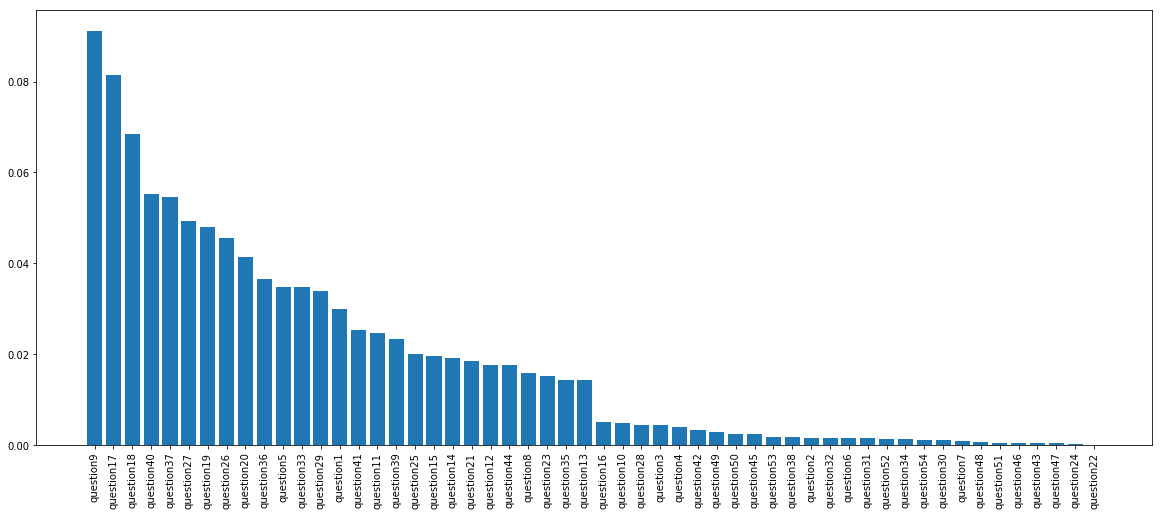

In [31]:
classifier = classifier.fit(divorces['data'], divorces['target'])

# treści pytań są długie, wykres etykietujemy więc samymi ich numerami
labels = np.array(['question' + str(i) for i in range(1, len(divorces['feature_names']) + 1)])
plot_feature_importances(classifier, labels, size=(20, 8))

## Macierz kowariancji

### Wariancja

**Wariancja** jest intuicyjnie utożsamiana ze zróżnicowaniem zbiorowości;
jest średnią arytmetyczną kwadratów różnic poszczególnych wartości cechy od wartości oczekiwanej.
Wariancję zmiennej losowej X oznaczamy jako:

\begin{align}
Var(X)\newline
D^2(X)
\end{align}

I obliczamy za pomocą wzoru:

\begin{align}
D^2(X) = E(X^2) - [E(X)]^2
\end{align}

Gdzie E[X] jest wartością oczekiwaną zmiennej losowej X.

### Kowariancja

**Kowariancją** nazywamy zależnośc liniową między dwowa zmiennymi losowymi X i Y.
Kowariancję oznaczamy jako:

\begin{align}
cov(X,Y)
\end{align}

I wyliczamy ze wzoru:

\begin{align}
cov(X,Y) = E(X * Y) - E(X) * E(Y)
\end{align}

### Macierz kowariancji

#### 1. Sposób wyliczania
**Macierz kowariancji** jest uogólnieniem pojęcia wariancji dla przypadków wielowymiarowych. Dla wektora losowego

\begin{align}
(X_1,X_2,...,X_n)
\end{align}

Ma ona postać:

\begin{equation*}
\Sigma =  \begin{vmatrix}
\ \sigma^2_1 & \sigma_{12} & ... & \sigma_{1n}  \\
\ \sigma_{21} & \sigma^2_2 & ... & \sigma_{2n}  \\
\ ... & ... & ... & ... \\
\ \sigma_{n1} & \sigma_{n2} & ... & \sigma^2_n
\end{vmatrix}
\end{equation*}

Gdzie:

\begin{align}
\sigma^2_i = D^2(X_i) - wariancja\; zmiennej\; X_i \\
\end{align}

\begin{align}
\sigma_{ij} = cov(X_i, X_j) - kowariancja\; miedzy\; zmiennymi\; losowymi\; X_i\; i\; X_j
\end{align}

#### 2. Macierz kowariancji w Pythonie

Do wyznaczania macierzy kowariancji używamy funkcji cov z biblioteki numpy. Wylicza ona macierz na podstawie podanych tablic i wag.

<center>numpy.cov(m, y=None, rowvar=True, bias=False, ddof=None, fweights=None, aweights=None)</center>

gdzie najważniejsze argumenty to:
<ul>
    <li> m - jedno- lub dwu- wymiarowa tablic danych, zawiarająca różne zmienne i obserwacje</li>
    <li>bias - odpowiada za rodzaj normalizacji</li>
    <li>fweights - jednowymiarowa tablica liczb całkowitych, wyznaczająca wagi częstotliwości, czyli ile razy dana obserwacja powinna być powtórzona</li>
    <li>aweights - jednowymiarowa tablica, odpowiedzialna za wagi ("ważność") danych obserwacji.</li>
</ul>

#### 3. Działanie funkcji numpy.cov

Mamy daną tablicę m, gdzie kolumny są poszeczególnymi obserwacjami, niech f = fweight i a = aweight. Wyliczanie macierzy kowariancji następuje w podany sposób:

=> w = f * a<br>
=> v1 = np.sum(w)<br>
=> v2 = np.sum(w * a)<br>
=> m -= np.sum(m * w, axis=1, keepdims=True) / v1<br>
=> cov = np.dot(m * w, m.T) * v1 / (v1**2 - ddof * v2)<br>

In [29]:
cancer.data[0:3,0:3]

array([[ 1.14875667, -0.56526506,  2.25574689],
       [-0.80545038, -0.8762436 , -0.86865246],
       [ 0.23703554, -0.78008338, -0.39800791]])

In [30]:
np.cov(cancer.data[0:3,0:3])

array([[2.02023437e+00, 1.21319589e-02, 3.53036081e-01],
       [1.21319589e-02, 1.51063474e-03, 1.91735968e-02],
       [3.53036081e-01, 1.91735968e-02, 2.63965453e-01]])

In [31]:
cancer.data

array([[ 1.14875667, -0.56526506,  2.25574689, ...,  2.75062224,
         1.30768627, -1.35929347],
       [-0.80545038, -0.8762436 , -0.86865246, ..., -0.24388967,
        -0.37561196, -0.36920322],
       [ 0.23703554, -0.78008338, -0.39800791, ...,  1.152255  ,
         0.52740741, -0.02397438],
       ...,
       [-0.89141612, -0.2573709 , -0.89558693, ..., -1.10454895,
        -0.80958728,  1.37485378],
       [ 0.32663363,  0.68608793,  1.04369542, ...,  1.91908301,
         1.43042677,  2.23792588],
       [ 0.75282996,  0.3830925 , -0.56103238, ..., -0.04813821,
        -1.85901852,  0.76418957]])

In [34]:
np.cov(cancer.data)

array([[ 1.87771887e+00,  6.85671823e-02,  3.16248346e-01, ...,
        -1.01302148e+00,  4.63493543e-02, -8.35669944e-01],
       [ 6.85671823e-02,  1.50149947e-01,  1.16817456e-01, ...,
         6.73816307e-02,  1.06062736e-01, -5.16208641e-02],
       [ 3.16248346e-01,  1.16817456e-01,  3.71028617e-01, ...,
        -1.55389608e-03,  1.77501334e-01, -3.60283290e-01],
       ...,
       [-1.01302148e+00,  6.73816307e-02, -1.55389608e-03, ...,
         8.72724396e-01,  2.50417088e-01,  3.74468121e-01],
       [ 4.63493543e-02,  1.06062736e-01,  1.77501334e-01, ...,
         2.50417088e-01,  5.96571008e-01, -2.05930567e-02],
       [-8.35669944e-01, -5.16208641e-02, -3.60283290e-01, ...,
         3.74468121e-01, -2.05930567e-02,  1.35383083e+00]])

### Heat map

**Heat mapa** jest graficzną reprezentacją danych, gdzie każdy wartość elementu macierzy jest reprezentowana przez dany kolor.

<img src="heat_map.png">

In [23]:
import seaborn as sns

In [24]:
matrix_data = np.cov(divorces['data'])

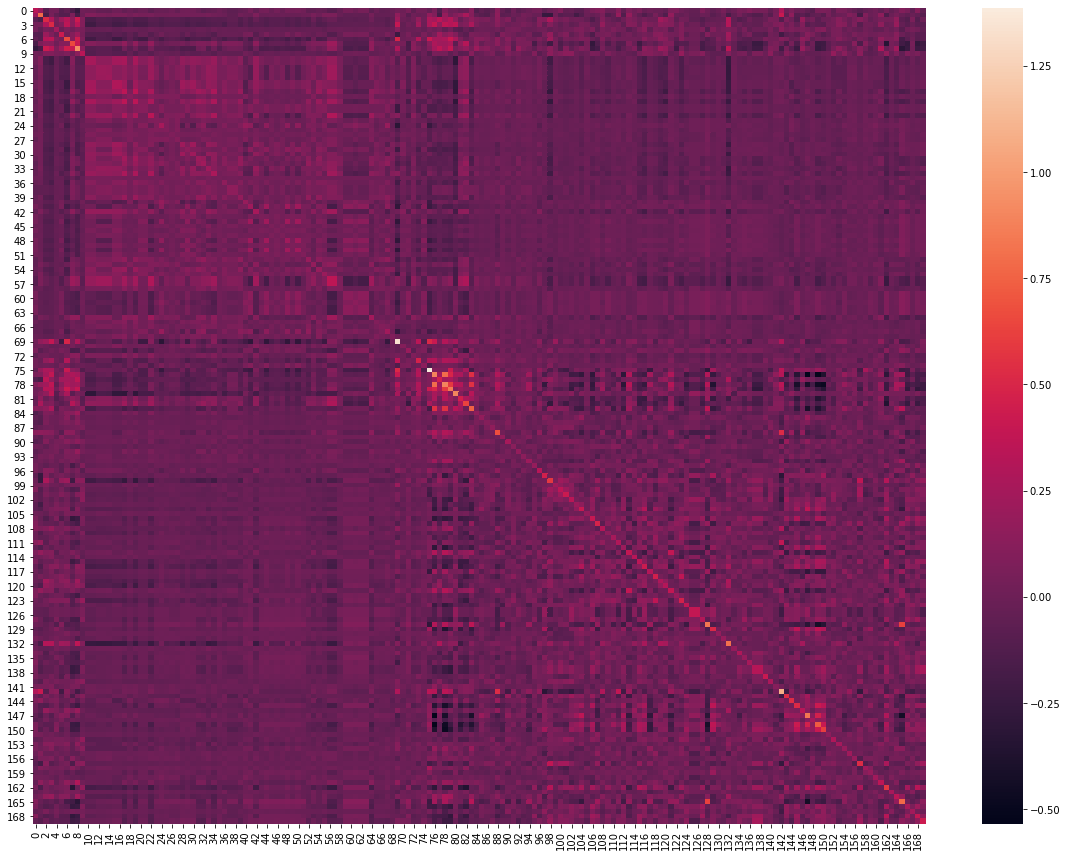

In [25]:
plt.subplots(figsize=(20,15))
sns.heatmap(matrix_data )

Heat mapy pozwalają na łatwiejsze znalezienie obszarów o większym znaczeniu w przypadku dużej ilości danych. Są one łatwiejsze do przeanalizowania niż surowe dane liczbowe.

Z takiej heat mapy możemy odczytać jak dużą kowariancją cechują się dwie zmienne losowe. Duża kowariancja między dwiema zmiennymi wskazuje, że są one wysoce „skorelowane” - zawierają informacje, które można przewidzieć lub przedstawić pojedynczą zmienną.

Klasyfikowanie dużych danych bywa czasochłonne i zasobożerne. Informacje, które można wywnioskować z heat mapy pozwalają nam wyłonić z pełnego zbioru danych odpowiedni fragment, który następnie posłuży do tworzenia bardziej optymalnych klasyfikatorów.

## Transformacja PCA

Transformacja PCA (Principal Component Analysis) jest algorytmem analizy danych. Wykorzystuje informacje o powiązaniach pomiędzy danymi wejściowymi. Umożliwia to dokonanie selekcji i "kompresji" danych bez utraty istotnych informacji pierwotnego zestawu danych. PCA może być wykorzystane właśnie w problemach kompresji, analizy oraz przetwarzania złożonych zbiorów danych tak, aby wyłuszczyć z nich składaniki o największej zmienności i największym wpływie na pozostałe informacje.

Transfomacja PCA jest przekształceniem liniowym Y = W * X, gdzie Y - macierz przestrzeni wyjściowe, która zachowuje najistotniejsze informacje danych wejściowych X, a W jest macierzą przekształceń PCA.

### Sposób wyliczania

Podobnie jak w przypadku macierzy kowariancji, danymi wejściowymi jest macierz X, w której każdy wiersz to jedna obserwacja. Wielkość takiej macierzy to N x P (gdzie N - wielkość wektora danych, a  P - ilość obserwacji).

Dla tak przygotowanych danych należy wyznaczyć macierz autokorelacji.

\begin{align}
R_{xx} = \frac{1}{P} XX^T
\end{align}

Macierz Rxx posiada wymiary N × N. Informuje nas ona w jakim stopniu dane są skorelowane. Koeljnym krokiem algorytmu jest wyznaczenie wartości własnych macierzy Rxx oraz odpowiadających im wektorów własnych. Wartości te, wraz z odpowiadającymi im wektorami własnymi należy uszeregować malejąco. W ten sposób uzyskuje się macierz diagonalną:

\begin{equation*}
D =  \begin{vmatrix}
\ \lambda_1 & 0 & ... & 0  \\
\ 0 & \lambda_2 & ... & 0  \\
\ ... & ... & ... & ... \\
\ 0 & 0 & ... & \lambda_N
\end{vmatrix}
\end{equation*}

Gdzie:

\begin{align}
\lambda_1 > \lambda_2 > .. > \lambda_N
\end{align}

to wartości własne. Macierzy odpowiada macierz wektorów własnych:

\begin{align}
V = [v_1, v_2, ..., v_N]
\end{align}

Istotnym krokiem transformacji jest ocena ile najistotniejszych czynników należy uwzględnić w przekształceniu. W tym celu należy wybrać pierwszy K największych wartości własnych macierzy D, odstających znacząco od pozostałych. W ten sposób otzywamujemy macierz przekształcenia uwzględniającą K znaczących wektorów własnych:

\begin{align}
W = [v_1, v_2, ..., v_K]
\end{align}

Finalnie, przekształcenie PCA danych wejściowych X przedstawia się jako przekształcenie liniowe wspomniane wcześniej:

\begin{align}
Y = WX
\end{align}

### Transformacja PCA w Pythonie

Do wyznaczania transformacji PCA używamy klasy PCA z sklearn.decomposition.

<center>sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)</center>

gdzie najważniejszy argument to n_components - ilość elemetów, które chcemy zachować w transformacji. Jeżeli nie podana, wynosi ona min(n_samples, n_features)

Klasa ta posiada m.in. pola:

<ul>
    <li>components_ - główne osie w przestrzeni cech, reprezentujące kierunki maksymalnej wariancji danych</li>
    <li>explained_variance_ - wielkość wariancji dla każdego wybranego elementu</li>
    <li>explained_variance_ratio_ - procentowa wielkość wariancji dla każdego wybranego elementu</li>
    <li>n_features_ - liczba cech w danych traningowych</li>
    <li>n_samples_ - liczba próbek w danych traningowych</li>
</ul>

Funkcja fit(self, X[, y]) dopasowuje model X.

Funkcja transform(self, X) redukuje wielowymiarowość X.

Funckja fit_transform(self, X[, y]) dopasowuje i redukuje wielomianowowść modelu X.

In [275]:
from sklearn.decomposition import PCA
from PIL import Image
from numpy import asarray

In [276]:
pca = PCA()

In [277]:
pca.fit_transform(divorces['data'])

array([[-2.71560542e+00,  9.81032327e-02,  8.21666278e-01, ...,
         8.32936459e-02,  1.63868428e-01, -2.27468183e-01],
       [ 2.41461306e+00,  1.23993350e+00, -2.73937308e-01, ...,
         1.54941784e-01, -3.03923067e-02,  5.09779292e-01],
       [ 4.25987284e-01,  1.95997609e+00,  1.72663381e-01, ...,
         2.33608362e-02, -4.04644548e-03,  3.11563046e-02],
       ...,
       [-4.39064248e+00, -6.24259363e-01, -9.40943430e-01, ...,
        -5.06014890e-02, -2.00248108e-01, -1.85773384e-01],
       [-4.50716741e+00, -2.05965995e+00,  6.41161840e-01, ...,
        -1.09280151e-01,  1.22094824e-01,  4.50734102e-02],
       [-3.74270098e+00, -1.35068469e+00,  7.33459855e-01, ...,
        -2.27230073e-01,  2.31582755e-01,  1.16843989e-02]])

### Przykład działania

Będziemy przeprowadzać transformacje na dwie cechy.

In [278]:
pca = PCA(n_components = 5)

model = pca.fit(divorces['data'])
model_pc = model.transform(divorces['data'])

In [279]:
pd.DataFrame(data = divorces['data'], columns = divorces['feature_names'])

,We don't have time at home as partners.,"Even if I'm right in the discussion, I stay silent to hurt my spouse.",We are like two strangers who share the same environment at home rather than family.,I'd rather stay silent than discuss with my spouse.,I mostly stay silent to calm the environment a little bit.,I feel right in our discussions.,I wouldn't hesitate to tell my spouse about her/his inadequacy.,"When I discuss with my spouse, I stay silent because I am afraid of not being able to control my anger.",I'm not the one who's wrong about problems at home.,"When I discuss, I remind my spouse of her/his inadequacy.","When I argue with my spouse, Ä± only go out and I don't say a word.",I have nothing to do with what I've been accused of.,I'm not actually the one who's guilty about what I'm accused of.,I feel aggressive when I argue with my spouse.,"When we need it, we can take our discussions with my spouse from the beginning and correct it.",I'm not afraid to tell my spouse about her/his incompetence;,"When I discuss with my spouse, to contact him will eventually work.","I know we can ignore our differences, even if things get hard sometimes.",I know how my spouse wants to be taken care of when she/he sick.,"When discussing with my spouse, I usually use expressions such as 'you always' or 'you never' .",Most of our goals are common to my spouse.,I can use offensive expressions during our discussions.,I know my spouse's favorite food.,I can tell you what kind of stress my spouse is facing in her/his life.,My spouse and I have similar sense of entertainment.,I know my spouse's hopes and wishes.,Sometimes I think it's good for me to leave home for a while.,I have knowledge of my spouse's inner world.,"If one of us apologizes when our discussion deteriorates, the discussion ends.",I can use negative statements about my spouse's personality during our discussions.,I can insult my spouse during our discussions.,My discussion with my spouse is not calm.,"Most of our goals for people (children, friends, etc) are the same.",I know exactly what my wife likes.,My spouse and I have similar values in terms of personal freedom.,I enjoy our holidays with my wife.,I know what my spouse's current sources of stress are.,I know my spouse's basic anxieties.,I know my spouse's friends and their social relationships.,I hate my spouse's way of open a subject.
0,-0.828792,-0.404272,-0.551439,0.361868,-1.268809,0.228240,0.327644,-0.803068,-0.379197,-0.160656,-0.738387,0.409816,0.407286,-0.684201,1.583883,-0.608507,-0.321591,0.237009,-0.864651,-0.036341,-1.112273,0.061511,-0.878349,-1.007874,-0.566660,-0.892322,0.035028,-1.068066,0.137772,-0.452757,-0.909509,-0.051570,-0.380814,-0.958811,-1.128805,-0.942357,-0.963665,-0.994792,-0.329414,-0.496518
1,-0.828792,-0.404272,-0.551439,-0.306801,0.218760,0.228240,1.006905,-0.171024,1.212493,-0.160656,-0.101200,1.073327,1.121087,-1.293176,1.583883,-0.007076,1.678548,1.602823,-0.171299,1.199247,1.709912,0.676626,-0.878349,0.325500,1.468527,-0.892322,1.225997,0.242918,1.370465,0.109058,-0.909509,0.532885,-1.048220,-0.268142,0.919916,1.651986,0.412999,-0.326355,-0.329414,1.237895
2,2.499427,0.326858,1.680577,-0.306801,-0.525025,0.228240,-0.351618,-0.171024,-1.175042,-0.160656,0.535987,-0.917206,-1.020315,0.533749,0.166725,-0.007076,0.345122,0.237009,-0.864651,0.581453,0.298820,-0.553603,-0.256185,0.325500,0.111736,0.474297,0.630512,0.242918,0.137772,-0.452757,-0.365085,-0.051570,0.953998,-0.268142,1.602823,-0.293771,0.412999,0.342083,0.337257,-0.496518
3,2.499427,-0.404272,2.796586,0.361868,0.218760,0.228240,-0.351618,-0.171024,0.416648,-0.160656,-0.101200,0.409816,0.407286,-0.075226,0.875304,-0.007076,0.345122,0.237009,-0.171299,0.581453,1.004366,0.061511,-0.256185,-0.341187,0.790131,-0.209012,0.035028,0.242918,0.754118,0.109058,-0.365085,0.532885,1.621404,-0.268142,0.919916,1.003400,-0.275333,-0.326355,1.003929,0.659757
4,0.280615,-0.404272,-0.551439,-0.306801,0.218760,-0.653596,-0.351618,-0.803068,-0.379197,-0.

In [280]:
pd.DataFrame(data = model_pc, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4','principal component 5'])

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-2.715605,0.098103,0.821666,-1.124722,1.711504
1,2.414613,1.239933,-0.273937,-1.295463,2.251730
2,0.425987,1.959976,0.172663,2.963106,-0.706512
3,1.922123,2.386541,0.870573,2.932251,0.980046
4,-3.300918,-0.070437,-0.742506,0.382754,0.445173
...,...,...,...,...,...
165,-3.883190,0.889201,3.453061,-2.697467,0.358084
166,-4.332214,-2.227939,0.604140,-0.291516,0.161748
167,-4.390642,-0.624259,-0.940943,0.116325,-0.607682
168,-4.507167,-2.059660,0.641162,-0.571096,0.612361


Na podstawie 40 originalnych cech powstało 5 nowych.

#### Nowe cechy

In [281]:
from sklearn import preprocessing

df = pd.DataFrame(data = divorces['data'], columns = divorces['feature_names'])
pca.fit_transform(divorces['data'])
data_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns) 
pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC1','PC2','PC3','PC4','PC5'])

,We don't have time at home as partners.,"Even if I'm right in the discussion, I stay silent to hurt my spouse.",We are like two strangers who share the same environment at home rather than family.,I'd rather stay silent than discuss with my spouse.,I mostly stay silent to calm the environment a little bit.,I feel right in our discussions.,I wouldn't hesitate to tell my spouse about her/his inadequacy.,"When I discuss with my spouse, I stay silent because I am afraid of not being able to control my anger.",I'm not the one who's wrong about problems at home.,"When I discuss, I remind my spouse of her/his inadequacy.","When I argue with my spouse, Ä± only go out and I don't say a word.",I have nothing to do with what I've been accused of.,I'm not actually the one who's guilty about what I'm accused of.,I feel aggressive when I argue with my spouse.,"When we need it, we can take our discussions with my spouse from the beginning and correct it.",I'm not afraid to tell my spouse about her/his incompetence;,"When I discuss with my spouse, to contact him will eventually work.","I know we can ignore our differences, even if things get hard sometimes.",I know how my spouse wants to be taken care of when she/he sick.,"When discussing with my spouse, I usually use expressions such as 'you always' or 'you never' .",Most of our goals are common to my spouse.,I can use offensive expressions during our discussions.,I know my spouse's favorite food.,I can tell you what kind of stress my spouse is facing in her/his life.,My spouse and I have similar sense of entertainment.,I know my spouse's hopes and wishes.,Sometimes I think it's good for me to leave home for a while.,I have knowledge of my spouse's inner world.,"If one of us apologizes when our discussion deteriorates, the discussion ends.",I can use negative statements about my spouse's personality during our discussions.,I can insult my spouse during our discussions.,My discussion with my spouse is not calm.,"Most of our goals for people (children, friends, etc) are the same.",I know exactly what my wife likes.,My spouse and I have similar values in terms of personal freedom.,I enjoy our holidays with my wife.,I know what my spouse's current sources of stress are.,I know my spouse's basic anxieties.,I know my spouse's friends and their social relationships.,I hate my spouse's way of open a subject.
PC1,0.055657,0.106367,0.085048,0.120104,0.122175,0.134737,0.135275,0.144973,0.149550,0.146849,0.150931,0.151528,0.157484,0.160341,0.154536,0.167397,0.160571,0.163805,0.174003,0.165440,0.162811,0.168947,0.176170,0.172103,0.169489,0.170225,0.164668,0.172482,0.166139,0.176688,0.177399,0.170932,0.169833,0.177302,0.168956,0.173131,0.175936,0.172514,0.173599,0.172487
PC2,0.109797,-0.431664,0.326144,-0.372041,-0.355503,-0.037834,-0.189375,-0.287908,-0.073243,-0.063659,-0.171007,-0.095375,-0.079170,-0.005526,0.202537,-0.061851,0.176771,0.134417,0.025345,0.079171,0.196731,-0.011621,-0.097649,0.067578,0.053643,0.048934,-0.072135,-0.000934,0.124384,-0.012151,-0.054849,0.068995,0.122538,0.017098,0.166107,0.077597,0.023336,0.084580,0.103998,0.029853
PC3,0.429408,0.003569,0.113134,-0.193513,-0.234097,0.172871,0.236550,-0.060291,0.215241,0.304545,-0.074565,0.029458,0.097558,0.161422,-0.020823,0.162724,-0.083497,-0.211884,-0.093541,0.187706,-0.098943,0.200643,-0.046524,-0.171711,-0.029779,-0.112713,0.001126,-0.053085,-0.037502,0.158644,0.093849,0.164301,-0.171179,-0.051344,-0.173515,-0.133694,-0.105323,-0.208662,-0.101666,0.108902
PC4,0.642439,0.067962,0.491385,0.223385,0.264555,-0.082065,-0.108453,0.132090,-0.142924,-0.152050,0.160912,-0.052933,-0.086329,-0.105233,-0.007524,-0.071742,-0.042865,-0.087930,-0.041278,-0.035109,0.035513,-0.116848,-0.049426,-0.009168,0.012927,-0.020646,0.166588,-0.029247,0.000766,-0.078137,-0.065087,-0.091503,0.032278,0.010522,0.030022,-0.057988,0.069672,0.015472,0.001377,-0.031847
PC5,-0.199429,0.056969,0.269192,0.091875,-0.037231,0.441324,-0.143140,0.088621,0.372279,-0.152751,0.0

Jak widać obie nowe cechy są pewną kombinacją originalnych cech.

#### Wizualizacja ważności cech

Cechy originalne

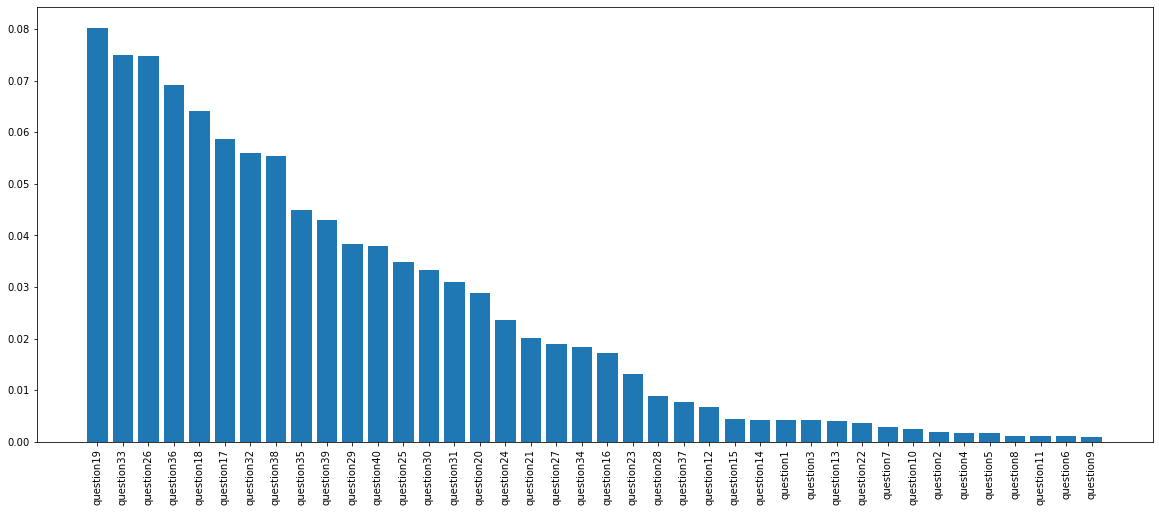

In [282]:
classifier = classifier.fit(divorces['data'], divorces['target'])

# treści pytań są długie, wykres etykietujemy więc samymi ich numerami
labels = np.array(['question' + str(i) for i in range(1, len(divorces['feature_names']) + 1)])
plot_feature_importances(classifier, labels, size=(20, 8))

Nowe cechy

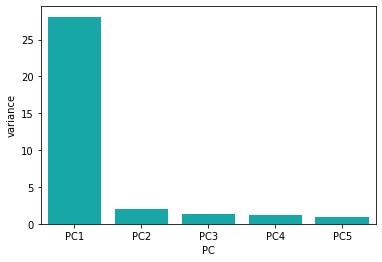

In [283]:
df = pd.DataFrame({'variance':pca.explained_variance_, 'PC':['PC1','PC2','PC3','PC4','PC5']})
sns.barplot(x='PC',y="variance", data=df, color="c")